# NN cascade for URZ correct nodes
### With normalization of Features as in iwt_nnet.c : iwt_normalize()

* Radek Hofman, Jan 2018
* we restruict ourselves to data up to 2017/01/01 00:00 for training
* N phases just between 2016 and 2017 where we included all NOISE phases also those not identified by automatic as noise before

### Imports and axiliary functions and stuff

In [222]:
%load_ext sql
%matplotlib inline

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [223]:
import os
import numpy
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt

In [224]:
with open(os.path.join('/','home','hofman','.dbp.txt'), 'r') as f: password = f.read().strip()

In [225]:
query = "oracle://hofman:%s@mycelium.ctbto.org:1521/udb" % password
%sql $query

'Connected: hofman@udb'

In [226]:
% sql select count(*) from ml_features where sta='URZ'

0 rows affected.


COUNT(*)
362407


In [227]:
def plot(history, semilog=False):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.plot(history['acc'], label='acc')
    ax.plot(history['val_acc'], label='val_acc')
    ax.set_ylabel('accuracy')
    if semilog:
        ax.set_yscale('log')
    plt.legend(loc='best')
    ax = fig.add_subplot(212)
    ax.plot(history['loss'], label='loss')
    ax.plot(history['val_loss'], label='val_loss')
    plt.legend(loc='best')
    if semilog:
        ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

In [228]:
#load data from oracle do pandas
import cx_Oracle
connection = cx_Oracle.connect('hofman', password, 'udb')

### What is the misclassification rate now for all arrivals in our DB?

* #(class_iphase != class_phase) / (#automatic which are not noise) 

In [229]:
#select from database required numbers
wrong_type = %sql select count(*) from ml_features where sta='URZ' and class_phase != class_iphase
total_number = %sql select count(*) from ml_features where sta='URZ' and phase!='N' and source!='M'

0 rows affected.
0 rows affected.


In [230]:
print('Percentage of misclassified initial wave types: %3.2f%%' % (wrong_type[0][0]/total_number[0][0]*100))

Percentage of misclassified initial wave types: 47.90%


### Dataframes per class phase type - RESTRICTION TO DATA BEFORE 2017

In [231]:
#1483228800.00000 2017001  2017/01/01 00:00:00.00000 Jan Sun
query = """select * from ml_features where sta='URZ' and class_phase='regS' and time < 1483228800"""
df_S_all = pd.read_sql(query, con=connection)

In [232]:
df_S_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,25050735,URZ,1.125386e+09,Sx,regS,Sn,regS,1.000,A,0.166667,...,1.526004,0.786459,1.174982,0.0,0.006667,1.216724,0.363039,2.166968,1.844924,0.626604
1,25058004,URZ,1.125423e+09,Lg,regS,Sn,regS,1.925,A,0.444444,...,2.762988,15.337161,15.337161,0.3,-0.090000,0.423843,1.384683,0.724611,6.547078,1.569841
2,25075768,URZ,1.125508e+09,Lg,regS,Sn,regS,1.050,A,0.333333,...,1.395858,1.296030,2.398118,0.0,-0.050000,0.713705,1.641215,0.940403,1.211333,1.909713
3,25092371,URZ,1.125587e+09,Sn,regS,Sn,regS,0.175,A,0.166667,...,1.746398,5.561389,2.205452,0.2,0.125000,1.155050,0.646231,0.997092,1.326985,4.507104
4,25094351,URZ,1.125598e+09,Sn,regS,Sn,regS,1.400,A,0.444444,...,2.816413,5.135686,8.557762,0.3,0.116667,1.682028,0.309588,2.783780,8.199625,2.007485


In [233]:
query = """select * from ml_features where sta='URZ' and class_phase='regP' and time < 1483228800"""
df_P_all = pd.read_sql(query, con=connection)

In [234]:
df_P_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,14972252,URZ,1.069735e+09,Pn,regP,Pn,regP,2.94244,A,0.166667,...,1.542596,0.124299,0.176237,0.1,0.100000,0.509125,0.983261,0.619635,0.118464,0.058735
1,14992929,URZ,1.070059e+09,Pn,regP,Pn,regP,0.00000,A,0.333333,...,1.301846,1.112025,0.258914,0.6,0.288333,3.730434,0.738458,0.704325,0.247701,0.060989
2,15029724,URZ,1.070386e+09,Pn,regP,Pn,regP,0.65000,A,0.166667,...,1.828008,0.132138,0.192003,0.3,0.266667,0.629496,0.632947,0.277982,0.542543,0.041916
3,15031571,URZ,1.070403e+09,Pn,regP,Pn,regP,3.22500,A,0.444444,...,1.375773,0.282216,0.589090,0.1,0.050000,0.924411,0.941318,0.304547,0.520954,0.131296
4,15073977,URZ,1.070752e+09,Pg,regP,Pn,regP,0.00000,A,0.166667,...,3.529159,0.085323,0.486815,0.3,0.190000,0.211185,0.225393,0.257161,0.413598,0.287086


In [235]:
query = """select * from ml_features where sta='URZ' and class_phase='tele' and time < 1483228800"""
df_T_all = pd.read_sql(query, con=connection)

In [236]:
df_T_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,28541585,URZ,1.143123e+09,P,tele,P,tele,0.550,A,0.666667,...,1.702892,0.042081,0.042081,0.1,-0.065000,0.467387,0.594238,0.057473,0.053682,0.463873
1,28556291,URZ,1.143197e+09,P,tele,P,tele,0.500,A,0.333333,...,1.957241,0.223522,0.223522,0.0,0.000000,0.954016,0.705002,1.308694,0.193754,0.114283
2,28557837,URZ,1.143204e+09,P,tele,P,tele,3.100,A,0.333333,...,1.190828,0.240041,0.613747,0.2,-0.265000,0.577677,1.020239,0.372745,0.277075,0.067225
3,28559193,URZ,1.143210e+09,P,tele,P,tele,0.000,A,0.333333,...,1.531207,0.084376,0.084376,0.2,0.100000,0.689514,0.333741,0.336678,0.119060,0.092935
4,28561877,URZ,1.143223e+09,P,tele,P,tele,0.375,A,0.444444,...,2.808070,0.038871,0.097918,0.2,0.153333,0.358785,0.042658,0.127151,0.064076,0.062188


In [485]:
query = """select * from ml_features where sta='URZ' and class_phase='N' and time < 1483228800"""
df_N_all = pd.read_sql(query, con=connection)

In [369]:
df_N_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,110566681,URZ,1.451612e+09,Sx,N,None,N,0.0,Z,1.000000,...,52.587402,1.614739e+03,1.936566e+01,0.0,0.190000,72.666879,41.241983,9.685020e+01,3.041792e+03,7.244073e+03
1,110567260,URZ,1.451614e+09,Sx,N,None,N,0.0,Z,0.166667,...,5436.024100,2.198101e+08,2.198101e+08,-0.1,-0.320000,16702.462000,170296.330000,1.558108e+06,7.759200e+07,3.021482e+08
2,110567262,URZ,1.451614e+09,Sx,N,None,N,0.0,Z,0.666667,...,35.065924,3.160446e+01,2.322374e+01,0.4,0.106000,17.477697,2.795683,8.508783e+00,3.473072e+01,7.039049e+02
3,110567263,URZ,1.451614e+09,Sx,N,None,N,0.0,Z,0.666667,...,14.875136,6.151265e+00,6.151265e+00,0.2,0.045000,39.610843,27.155523,2.735013e+00,4.063939e+01,7.479070e+02
4,110567264,URZ,1.451614e+09,Sx,N,None,N,0.0,Z,0.666667,...,11.192452,5.825284e+01,5.825284e+01,0.0,0.013333,61.172028,19.655401,3.542429e+00,2.502989e+01,9.454648e+02


In [370]:
#save to csv
#df_ora.to_csv('URZ_pandas.csv')

In [371]:
print('regS', df_S_all.shape)
print('regP', df_P_all.shape)
print('tele', df_T_all.shape)
print('noise', df_N_all.shape)

regS (10514, 25)
regP (11127, 25)
tele (35887, 25)
noise (41337, 25)


In [372]:
#before restriction
#how much data we have
print('regS', df_S_all.shape)
print('regP', df_P_all.shape)
print('tele', df_T_all.shape)
print('noise', df_N_all.shape)

regS (10514, 25)
regP (11127, 25)
tele (35887, 25)
noise (41337, 25)


# Definition of input and output

In [373]:
# columns corresponding to input
x_indices = ['PER', 'RECT', 'PLANS', 'INANG1', 'INANG3', 'HMXMN', 'HVRATP', 'HVRAT', 'NAB', 'TAB',  
             'HTOV1', 'HTOV2', 'HTOV3', 'HTOV4', 'HTOV5']
print('features count:', len(x_indices))
# columns corresponding to output
y_indices = ['CLASS_PHASE']

metadata = ['ARID','STA','TIME','IPHASE','CLASS_IPHASE','PHASE','CLASS_PHASE','RETIME','SOURCE']

features count: 15


# Dataset for first phase of the cascade: N vs TPS

In [374]:
#counts of all classes
ns = df_S_all.shape[0]
np = df_P_all.shape[0]
nt = df_T_all.shape[0]
nn = df_N_all.shape[0]

#those from automatic
nsa = df_S_all[df_S_all['SOURCE'] != 'M'].shape[0]
npa = df_P_all[df_P_all['SOURCE'] != 'M'].shape[0]
nta = df_T_all[df_T_all['SOURCE'] != 'M'].shape[0]
nna = df_N_all[df_N_all['SOURCE'] != 'M'].shape[0]


#we build a balanced datased - the same portion of regS, regP and tele
#we have this count of phases
samp_count = min(nsa, npa, nta)

#sample TPS dataset, random_state is a seed
ssS = df_S_all[df_S_all['SOURCE'] != 'M'].sample(samp_count, random_state=11)
ssP = df_P_all[df_P_all['SOURCE'] != 'M'].sample(samp_count, random_state=13)
ssT = df_T_all[df_T_all['SOURCE'] != 'M'].sample(samp_count, random_state=17)
TPS_data = pd.concat([ssS, ssP, ssT])

#sample noise phases
N_data = df_N_all[df_N_all['SOURCE'] != 'M'].sample(3*samp_count, random_state=23)

#lets shuffle dataset
TPS_data = TPS_data.sample(frac=1, random_state=51).reset_index(drop=True)
N_data = N_data.sample(frac=1, random_state=101).reset_index(drop=True)

print(ssS.shape, ssP.shape, ssT.shape)
print(TPS_data.shape)
print(N_data.shape)

(8512, 25) (8512, 25) (8512, 25)
(25536, 25)
(25536, 25)


### Normalization of data

* normalization according to iwt_nnet.c : iwt_normalize()


In [375]:
# check on positivity of all features which are going to be log10-ed:)
# check TPS data
print('TPS')
print(TPS_data['HVRAT'][TPS_data['HVRAT']<=0])
print(TPS_data['HVRATP'][TPS_data['HVRATP']<=0])
print(TPS_data['HMXMN'][TPS_data['HMXMN']<=0])
print(TPS_data['HTOV1'][TPS_data['HTOV1']<=0])
print(TPS_data['HTOV2'][TPS_data['HTOV2']<=0])
print(TPS_data['HTOV3'][TPS_data['HTOV3']<=0])
print(TPS_data['HTOV4'][TPS_data['HTOV4']<=0])
print(TPS_data['HTOV5'][TPS_data['HTOV5']<=0])
# check NOISE data
print('NOISE')
print(N_data['HVRAT'][N_data['HVRAT']<=0])
print(N_data['HVRATP'][N_data['HVRATP']<=0])
print(N_data['HMXMN'][N_data['HMXMN']<=0])
print(N_data['HTOV1'][N_data['HTOV1']<=0])
print(N_data['HTOV2'][N_data['HTOV2']<=0])
print(N_data['HTOV3'][N_data['HTOV3']<=0])
print(N_data['HTOV4'][N_data['HTOV4']<=0])
print(N_data['HTOV5'][N_data['HTOV5']<=0])

TPS
Series([], Name: HVRAT, dtype: float64)
Series([], Name: HVRATP, dtype: float64)
Series([], Name: HMXMN, dtype: float64)
Series([], Name: HTOV1, dtype: float64)
Series([], Name: HTOV2, dtype: float64)
Series([], Name: HTOV3, dtype: float64)
Series([], Name: HTOV4, dtype: float64)
Series([], Name: HTOV5, dtype: float64)
NOISE
Series([], Name: HVRAT, dtype: float64)
Series([], Name: HVRATP, dtype: float64)
Series([], Name: HMXMN, dtype: float64)
Series([], Name: HTOV1, dtype: float64)
Series([], Name: HTOV2, dtype: float64)
Series([], Name: HTOV3, dtype: float64)
Series([], Name: HTOV4, dtype: float64)
Series([], Name: HTOV5, dtype: float64)


In [376]:
# normalize TPS
TPS_data_norm = TPS_data.copy(deep=True)
TPS_data_norm['INANG1'] /= 90.
TPS_data_norm['INANG3'] /= 90.
TPS_data_norm['HMXMN'] = numpy.log10(TPS_data['HMXMN'])
TPS_data_norm['HVRATP'] = numpy.log10(TPS_data['HVRATP'])
TPS_data_norm['HVRAT'] = numpy.log10(TPS_data['HVRAT'])
TPS_data_norm['HTOV1'] = numpy.log10(TPS_data['HTOV1'])
TPS_data_norm['HTOV2'] = numpy.log10(TPS_data['HTOV2'])
TPS_data_norm['HTOV3'] = numpy.log10(TPS_data['HTOV3'])
TPS_data_norm['HTOV4'] = numpy.log10(TPS_data['HTOV4'])
TPS_data_norm['HTOV5'] = numpy.log10(TPS_data['HTOV5'])

# normalize NOISE
N_data_norm = N_data.copy(deep=True)
N_data_norm['INANG1'] /= 90.
N_data_norm['INANG3'] /= 90.
N_data_norm['HMXMN'] = numpy.log10(N_data['HMXMN'])
N_data_norm['HVRATP'] = numpy.log10(N_data['HVRATP'])
N_data_norm['HVRAT'] = numpy.log10(N_data['HVRAT'])
N_data_norm['HTOV1'] = numpy.log10(N_data['HTOV1'])
N_data_norm['HTOV2'] = numpy.log10(N_data['HTOV2'])
N_data_norm['HTOV3'] = numpy.log10(N_data['HTOV3'])
N_data_norm['HTOV4'] = numpy.log10(N_data['HTOV4'])
N_data_norm['HTOV5'] = numpy.log10(N_data['HTOV5'])

### The same for manually added arrivals

In [377]:
import keras.utils

### Define train/test ratio

In [378]:
train_test_split_ratio = 0.9
samp_count_train = int(TPS_data_norm.shape[0] * train_test_split_ratio)
samp_count_test = TPS_data_norm.shape[0] - samp_count_train
print('train count=', samp_count_train, 'test count=', samp_count_test)

train count= 22982 test count= 2554


In [380]:
TPS_train = TPS_data_norm[:samp_count_train]
TPS_test = TPS_data_norm[samp_count_train:]

N_train = N_data_norm[:samp_count_train]
N_test = N_data_norm[samp_count_train:]

print('TPS train:',TPS_train.shape,'TPS test:',TPS_test.shape)
print('N train:  ',N_train.shape,  'N test:  ',N_test.shape)

TPS train: (22982, 25) TPS test: (2554, 25)
N train:   (22982, 25) N test:   (2554, 25)


### Check interclass balance of TPS

In [381]:
print('T in TPS train:   ', TPS_train[TPS_train['CLASS_PHASE']=='tele'].shape)
print('regP in TPS train:', TPS_train[TPS_train['CLASS_PHASE']=='regP'].shape)
print('regS in TPS train:', TPS_train[TPS_train['CLASS_PHASE']=='regS'].shape)

print('T in TPS test:    ', TPS_test[TPS_test['CLASS_PHASE']=='tele'].shape)
print('regP in TPS test: ', TPS_test[TPS_test['CLASS_PHASE']=='regP'].shape)
print('regS in TPS test: ', TPS_test[TPS_test['CLASS_PHASE']=='regS'].shape)

T in TPS train:    (7648, 25)
regP in TPS train: (7709, 25)
regS in TPS train: (7625, 25)
T in TPS test:     (864, 25)
regP in TPS test:  (803, 25)
regS in TPS test:  (887, 25)


### Form train and test sets and shuffle

In [382]:
train = pd.concat([TPS_train, N_train]).sample(frac=1, random_state=31).reset_index(drop=True)
test =  pd.concat([TPS_test, N_test]).sample(frac=1, random_state=33).reset_index(drop=True)
#train.apply(pd.to_numeric, errors='ignore')
#test.apply(pd.to_numeric, errors='ignore')

# Some dataset insights

### Historgram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ecd4b2cc0>,
      dtype=object)

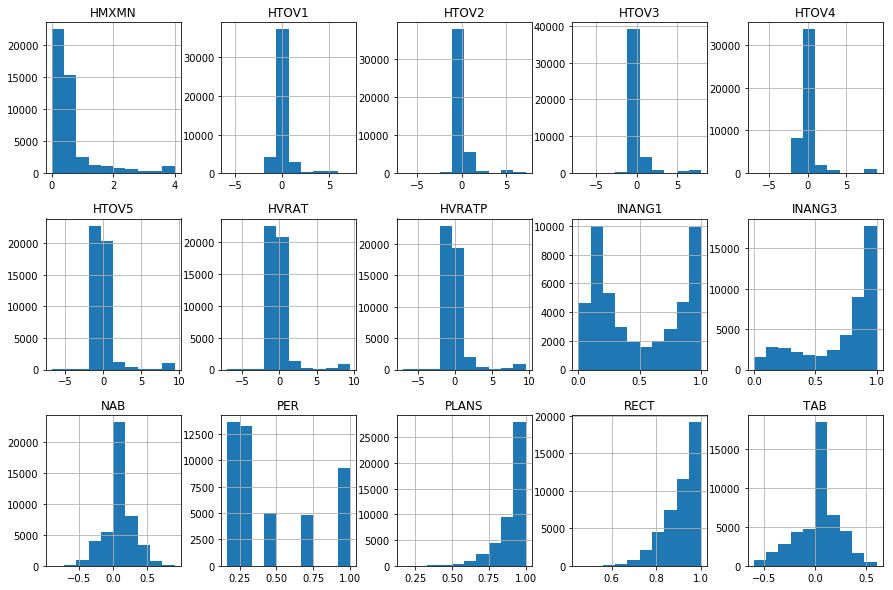

In [383]:
train.hist(figsize=(15,10), column=x_indices, layout=(3,5))

## Density plot

### Train

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ed3ad8748>,
      dtype=object)

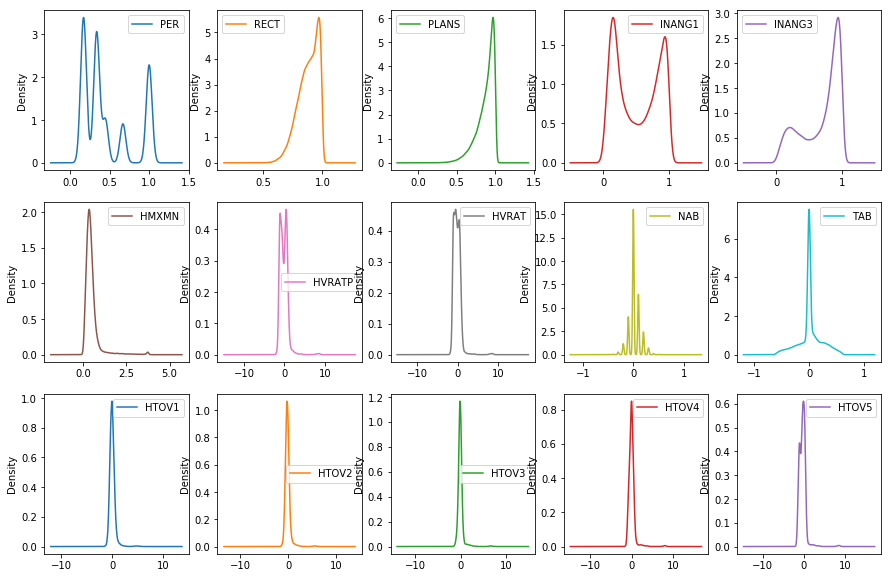

In [40]:
train[x_indices].plot(kind='density', figsize=(15,10), subplots=True, layout=(3,5), sharex=False)

### Test

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ed335ff28>,
      dtype=object)

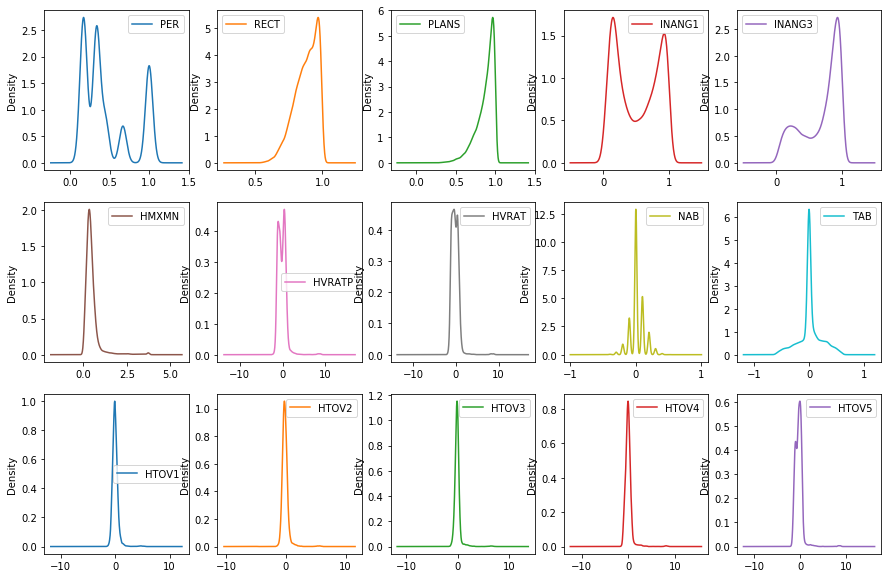

In [41]:
test[x_indices].plot(kind='density', figsize=(15,10), subplots=True, layout=(3,5), sharex=False)

### Correlation

[Text(0,0,'PER'),
 Text(0,0,'RECT'),
 Text(0,0,'PLANS'),
 Text(0,0,'INANG1'),
 Text(0,0,'INANG3'),
 Text(0,0,'HMXMN'),
 Text(0,0,'HVRATP'),
 Text(0,0,'HVRAT'),
 Text(0,0,'NAB'),
 Text(0,0,'TAB'),
 Text(0,0,'HTOV1'),
 Text(0,0,'HTOV2'),
 Text(0,0,'HTOV3'),
 Text(0,0,'HTOV4'),
 Text(0,0,'HTOV5')]

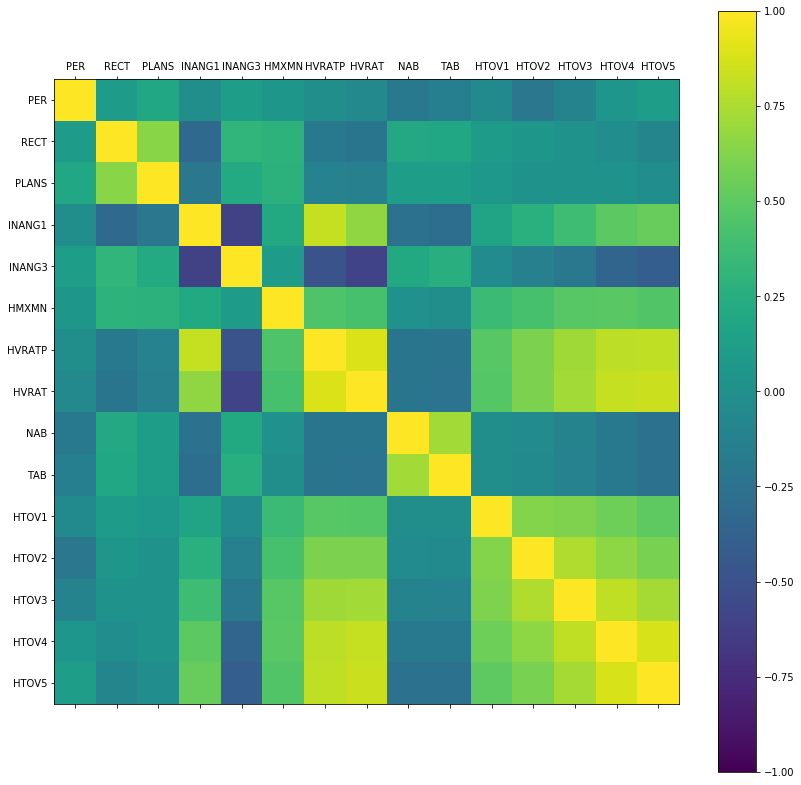

In [49]:
correlations = train[x_indices].corr()
# plot correlation matrix
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = numpy.arange(0,15,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(x_indices)
ax.set_yticklabels(x_indices)

### Scatter plot

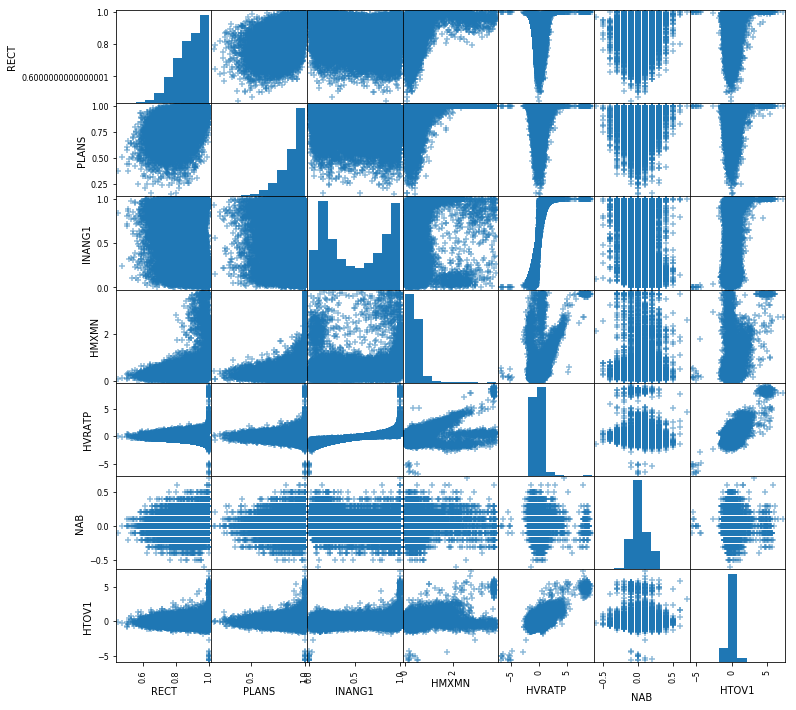

In [57]:
# Scatterplot Matrix
from pandas.plotting import scatter_matrix
scatter_matrix(train[['RECT', 'PLANS', 'INANG1', 'HMXMN', 'HVRATP', 'NAB', 'HTOV1']], figsize=(12,12), marker='+')
plt.show()

In [51]:
?scatter_matrix

### Extract features and class labels

In [384]:
train_X = train[x_indices].values.astype(float)
train_Y = train[y_indices]

test_X = test[x_indices].values.astype(float)
test_Y = test[y_indices]

train_Y_ = numpy.array(numpy.where(train_Y == 'N', 1, 0), dtype=float)
test_Y_ = numpy.array(numpy.where(test_Y == 'N', 1, 0), dtype=float)

#convert to categorical
train_Y = keras.utils.to_categorical(train_Y_)
test_Y = keras.utils.to_categorical(test_Y_)

test_metadata = test[metadata]

print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
print(test_metadata.shape)

(45964, 15) (45964, 2) (5108, 15) (5108, 2)
(5108, 9)


### verification, that if node1 < 0.5 => N (nodes start at 1: node1, node2)

In [385]:
train[y_indices+x_indices]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,N,1.000000,0.966213,0.995209,0.514372,0.792886,0.874693,-0.254189,-0.254189,0.0,0.000000,0.165961,-0.173518,-0.402781,-0.342542,-0.489132
1,tele,0.666667,0.968126,0.995290,0.961468,0.044997,0.695692,1.255392,1.954524,-0.2,-0.300000,-0.053182,-0.435041,0.536387,1.167010,0.235829
2,N,0.444444,0.818550,0.919289,0.110821,0.877488,0.327736,-0.698056,-0.656843,-0.2,-0.400000,0.002360,-0.736134,-0.415869,-0.722014,-0.292384
3,tele,0.333333,0.943713,0.945049,0.120936,0.973165,0.156967,-1.122324,-0.876259,0.1,0.060000,0.060300,-0.455974,-0.395611,-0.597594,-1.260718
4,regS,0.166667,0.775175,0.844131,0.930974,0.342398,0.241697,0.772940,0.470117,0.1,0.050000,0.666406,-0.346198,0.224729,0.183143,0.419024
5,regS,0.333333,0.924464,0.746878,0.954213,0.500421,0.503314,1.099512,0.157322,0.2,0.100000,-0.041253,0.060399,0.340061,-0.022914,0.221355
6,N,0.333333,0.809685,0.878951,0.128054,0.955843,0.280882,-0.668724,-0.679692,0.2,0.040000,-0.494466,0.246345,-0.147667,-0.883649,-0.834754
7,regS,0.166667,0.927800,0.844672,0.962552,0.047812,0.591591,0.902165,0.800302,-0.1,-0.192500,0.532642,0.243571,0.067960,0.532482,0.358581
8,tele,0.666667,0.982600,0.976307,0.196582,0.891720,0.383799,-1.160718,-0.922362,0.0,0.000000,-0.225145,0.138164,-0.988158,-1.031190,-1.289316
9,N,0.166667,0.825312,0.639537,0.979895,0.689574,0.413320,0.479233,0.221522,-0.1,-0.270000,0.267575,-0.186479,0.110714,0.192841,0.068504


In [386]:
train_Y

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

#### Ground truth for all 4 classes

In [387]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['N', 'regP', 'regS', 'tele'])
test_Y_GT = le.transform(test[y_indices])
train_Y_GT = le.transform(train[y_indices])
test_Y_GT[:20]

/dvlscratch/SHI/users/hofman/ML/env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([3, 0, 0, 3, 0, 1, 3, 2, 0, 2, 1, 1, 0, 2, 0, 0, 0, 3, 1, 0])

# Neural network

In [388]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam

In [389]:
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model = Sequential()
model.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1., clipvalue=0.5)
adam = Adam(lr=0.0001) #, clipnorm, clipvalue=0.5)

model.compile(
    loss = 'binary_crossentropy', 
    optimizer = 'adam',  # adam, sgd
    metrics = ['accuracy'])

In [390]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 6)                 96        
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 14        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [391]:
hist_keys = ('acc', 'val_acc', 'loss', 'val_loss')

In [392]:
history = {k : [] for k in hist_keys}

In [394]:
h = model.fit(train_X[:], train_Y[:], 
          epochs=500, 
          batch_size=512, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=(test_X, test_Y))

history = {k : history[k] + h.history[k] for k in hist_keys}

Train on 45964 samples, validate on 5108 samples
Epoch 1/500
45964/45964 [==============================] - 0s 4us/step - loss: 0.4039 - acc: 0.8161 - val_loss: 0.4158 - val_acc: 0.8111
Epoch 2/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4039 - acc: 0.8160 - val_loss: 0.4158 - val_acc: 0.8118
Epoch 3/500
45964/45964 [==============================] - 0s 4us/step - loss: 0.4039 - acc: 0.8163 - val_loss: 0.4158 - val_acc: 0.8111
Epoch 4/500
45964/45964 [==============================] - 0s 4us/step - loss: 0.4039 - acc: 0.8166 - val_loss: 0.4158 - val_acc: 0.8114
Epoch 5/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4038 - acc: 0.8166 - val_loss: 0.4158 - val_acc: 0.8130
Epoch 6/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4037 - acc: 0.8168 - val_loss: 0.4157 - val_acc: 0.8123
Epoch 7/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4038 - acc: 0.8162 - val_loss: 0.4157 - val_acc:

45964/45964 [==============================] - 0s 3us/step - loss: 0.4033 - acc: 0.8167 - val_loss: 0.4154 - val_acc: 0.8119
Epoch 61/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4033 - acc: 0.8168 - val_loss: 0.4154 - val_acc: 0.8119
Epoch 62/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4032 - acc: 0.8164 - val_loss: 0.4156 - val_acc: 0.8117
Epoch 63/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4032 - acc: 0.8157 - val_loss: 0.4158 - val_acc: 0.8107
Epoch 64/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4033 - acc: 0.8161 - val_loss: 0.4156 - val_acc: 0.8116
Epoch 65/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4032 - acc: 0.8164 - val_loss: 0.4153 - val_acc: 0.8111
Epoch 66/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4032 - acc: 0.8162 - val_loss: 0.4156 - val_acc: 0.8121
Epoch 67/500
45964/45964 [=====================

45964/45964 [==============================] - 0s 3us/step - loss: 0.4029 - acc: 0.8160 - val_loss: 0.4154 - val_acc: 0.8121
Epoch 120/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4030 - acc: 0.8163 - val_loss: 0.4156 - val_acc: 0.8105
Epoch 121/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4029 - acc: 0.8159 - val_loss: 0.4155 - val_acc: 0.8112
Epoch 122/500
45964/45964 [==============================] - 0s 4us/step - loss: 0.4029 - acc: 0.8160 - val_loss: 0.4154 - val_acc: 0.8112
Epoch 123/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4029 - acc: 0.8163 - val_loss: 0.4154 - val_acc: 0.8118
Epoch 124/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4029 - acc: 0.8166 - val_loss: 0.4153 - val_acc: 0.8113
Epoch 125/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4029 - acc: 0.8160 - val_loss: 0.4156 - val_acc: 0.8099
Epoch 126/500
45964/45964 [==============

45964/45964 [==============================] - 0s 3us/step - loss: 0.4027 - acc: 0.8165 - val_loss: 0.4155 - val_acc: 0.8119
Epoch 179/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4026 - acc: 0.8159 - val_loss: 0.4154 - val_acc: 0.8117
Epoch 180/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4027 - acc: 0.8164 - val_loss: 0.4151 - val_acc: 0.8119
Epoch 181/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4027 - acc: 0.8163 - val_loss: 0.4156 - val_acc: 0.8109
Epoch 182/500
45964/45964 [==============================] - 0s 4us/step - loss: 0.4027 - acc: 0.8167 - val_loss: 0.4152 - val_acc: 0.8113
Epoch 183/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4026 - acc: 0.8159 - val_loss: 0.4152 - val_acc: 0.8110
Epoch 184/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4027 - acc: 0.8164 - val_loss: 0.4152 - val_acc: 0.8117
Epoch 185/500
45964/45964 [==============

45964/45964 [==============================] - 0s 3us/step - loss: 0.4024 - acc: 0.8160 - val_loss: 0.4153 - val_acc: 0.8121
Epoch 238/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4025 - acc: 0.8163 - val_loss: 0.4152 - val_acc: 0.8111
Epoch 239/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4026 - acc: 0.8157 - val_loss: 0.4154 - val_acc: 0.8113
Epoch 240/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4024 - acc: 0.8162 - val_loss: 0.4153 - val_acc: 0.8115
Epoch 241/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4024 - acc: 0.8162 - val_loss: 0.4152 - val_acc: 0.8107
Epoch 242/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4024 - acc: 0.8163 - val_loss: 0.4153 - val_acc: 0.8124
Epoch 243/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4025 - acc: 0.8162 - val_loss: 0.4154 - val_acc: 0.8115
Epoch 244/500
45964/45964 [==============

45964/45964 [==============================] - 0s 3us/step - loss: 0.4022 - acc: 0.8164 - val_loss: 0.4154 - val_acc: 0.8115
Epoch 297/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4023 - acc: 0.8161 - val_loss: 0.4152 - val_acc: 0.8119
Epoch 298/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4023 - acc: 0.8162 - val_loss: 0.4156 - val_acc: 0.8097
Epoch 299/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4022 - acc: 0.8160 - val_loss: 0.4152 - val_acc: 0.8117
Epoch 300/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4023 - acc: 0.8165 - val_loss: 0.4152 - val_acc: 0.8115
Epoch 301/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4022 - acc: 0.8161 - val_loss: 0.4152 - val_acc: 0.8115
Epoch 302/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4022 - acc: 0.8160 - val_loss: 0.4151 - val_acc: 0.8118
Epoch 303/500
45964/45964 [==============

45964/45964 [==============================] - 0s 3us/step - loss: 0.4021 - acc: 0.8166 - val_loss: 0.4152 - val_acc: 0.8115
Epoch 356/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4020 - acc: 0.8164 - val_loss: 0.4152 - val_acc: 0.8113
Epoch 357/500
45964/45964 [==============================] - 0s 4us/step - loss: 0.4020 - acc: 0.8168 - val_loss: 0.4153 - val_acc: 0.8113
Epoch 358/500
45964/45964 [==============================] - 0s 4us/step - loss: 0.4020 - acc: 0.8163 - val_loss: 0.4154 - val_acc: 0.8095
Epoch 359/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4021 - acc: 0.8164 - val_loss: 0.4151 - val_acc: 0.8113
Epoch 360/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4021 - acc: 0.8163 - val_loss: 0.4152 - val_acc: 0.8117
Epoch 361/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4021 - acc: 0.8168 - val_loss: 0.4151 - val_acc: 0.8125
Epoch 362/500
45964/45964 [==============

45964/45964 [==============================] - 0s 3us/step - loss: 0.4018 - acc: 0.8163 - val_loss: 0.4156 - val_acc: 0.8113
Epoch 415/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4019 - acc: 0.8169 - val_loss: 0.4154 - val_acc: 0.8103
Epoch 416/500
45964/45964 [==============================] - 0s 4us/step - loss: 0.4020 - acc: 0.8165 - val_loss: 0.4151 - val_acc: 0.8113
Epoch 417/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4019 - acc: 0.8168 - val_loss: 0.4151 - val_acc: 0.8113
Epoch 418/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4019 - acc: 0.8165 - val_loss: 0.4152 - val_acc: 0.8109
Epoch 419/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4018 - acc: 0.8164 - val_loss: 0.4151 - val_acc: 0.8113
Epoch 420/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4018 - acc: 0.8165 - val_loss: 0.4152 - val_acc: 0.8097
Epoch 421/500
45964/45964 [==============

45964/45964 [==============================] - 0s 3us/step - loss: 0.4017 - acc: 0.8168 - val_loss: 0.4153 - val_acc: 0.8119
Epoch 474/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4017 - acc: 0.8166 - val_loss: 0.4151 - val_acc: 0.8115
Epoch 475/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4017 - acc: 0.8166 - val_loss: 0.4152 - val_acc: 0.8111
Epoch 476/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4017 - acc: 0.8165 - val_loss: 0.4151 - val_acc: 0.8123
Epoch 477/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4017 - acc: 0.8167 - val_loss: 0.4151 - val_acc: 0.8125
Epoch 478/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4017 - acc: 0.8170 - val_loss: 0.4153 - val_acc: 0.8109
Epoch 479/500
45964/45964 [==============================] - 0s 3us/step - loss: 0.4017 - acc: 0.8163 - val_loss: 0.4152 - val_acc: 0.8119
Epoch 480/500
45964/45964 [==============

In [395]:
train_Y[train_Y==0].shape, train_Y[train_Y==1].shape
test_Y[test_Y[:,0]==1].shape, test_Y[test_Y[:,1]==1].shape

((2554, 2), (2554, 2))

In [396]:
test_Y

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

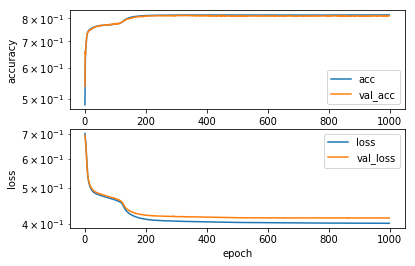

In [397]:
plot(history, semilog=True)

In [398]:
# calculate predicted values
Y_pred_ = model.predict(test_X)
# predictions are outputted as floats from [0,1]
print(Y_pred_[:10])

[[0.96229386 0.03770693]
 [0.21628729 0.7837191 ]
 [0.29597408 0.7040272 ]
 [0.79975003 0.2002485 ]
 [0.08055308 0.91944635]
 [0.7893142  0.21067744]
 [0.7024618  0.29753837]
 [0.942822   0.0571785 ]
 [0.110554   0.88944304]
 [0.6638948  0.33610296]]


In [399]:
Y_pred_.sum(axis=1).min(), Y_pred_.sum(axis=1).max()

(0.99996847, 1.0000429)

In [400]:
Y_pred = numpy.argmax(Y_pred_, axis=1)
Y_pred[:20]

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1])

In [401]:
from sklearn.metrics import confusion_matrix

# we must translate it to 0, 1 based on thresholding at 0.5
# where < 0.5 set to 0, to 1 otherwise
#Y_pred = numpy.where(Y_pred < 0.5, 0, 1)

# calculate confusion matrix
conf_mat = confusion_matrix(test_Y_, Y_pred)
print(conf_mat)

[[2114  440]
 [ 520 2034]]


In [402]:
## confusion matrix on Train?
Y_pred = numpy.argmax(model.predict(train_X), axis=1)
conf_mat = confusion_matrix(train_Y_, Y_pred)
print(conf_mat)

[[19212  3770]
 [ 4655 18327]]


In [403]:
#eval on test data
model.evaluate(test_X, test_Y)

5108/5108 [==============================] - 0s 7us/step


[0.4151430551951624, 0.8120595145804301]

In [404]:
model.evaluate(train_X, train_Y)

45964/45964 [==============================] - 0s 6us/step


[0.4014979158695513, 0.8167043773439739]

In [405]:
#save model and weights, NC = nodes correct
model.save('URZ_model_15-6-2_norm_NC_b2017_NTPS.h5')

# Neural network TP vs S 

* we need a new dataset for this

## Dataset for TP vs S

In [406]:
print(TPS_train.shape, TPS_test.shape)

(22982, 25) (2554, 25)


In [407]:
train_X_TPS = TPS_train[x_indices].values.astype(float)
train_Y_TPS = TPS_train[y_indices]

test_X_TPS = TPS_test[x_indices].values.astype(float)
test_Y_TPS = TPS_test[y_indices]

#regS = 0, T/regP = 1
train_Y_TPS_ = numpy.array(numpy.where(train_Y_TPS['CLASS_PHASE'] == 'regS', 1, 0), dtype=float)
test_Y_TPS_ = numpy.array(numpy.where(test_Y_TPS['CLASS_PHASE'] == 'regS', 1, 0), dtype=float)

#convert to categorical
train_Y_TPS = keras.utils.to_categorical(train_Y_TPS_)
test_Y_TPS = keras.utils.to_categorical(test_Y_TPS_)

print(train_X_TPS.shape, train_Y_TPS.shape, test_X_TPS.shape, test_Y_TPS.shape)

(22982, 15) (22982, 2) (2554, 15) (2554, 2)


### test if node3 < 0.5 => S

In [408]:
TPS_train[y_indices+x_indices]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,tele,0.666667,0.882568,0.958373,0.157113,0.904336,0.485956,-0.821541,-0.821541,0.0,0.000000,0.464077,0.238160,-0.285506,-0.241041,-0.927449
1,tele,0.666667,0.970364,0.907617,0.208997,0.976398,0.394147,-1.056929,-0.780702,0.0,0.000000,-0.140690,-0.259506,-0.345500,-0.357016,-0.012361
2,regP,0.444444,0.972336,0.968170,0.287208,0.719656,0.099224,-0.822671,-0.637867,0.2,0.040000,0.839792,-0.464646,0.022784,-0.850822,-0.665843
3,regP,0.333333,0.961154,0.968608,0.157537,0.887799,0.220673,-1.143233,-1.021936,0.0,0.000000,0.925975,0.187115,-0.342508,-0.593755,-1.253105
4,tele,0.333333,0.921997,0.868067,0.323496,0.944155,0.418986,-0.635144,-0.634917,0.0,0.000000,-0.438348,0.300001,-0.528825,-0.389658,-1.141463
5,regS,0.333333,0.862547,0.896826,0.941626,0.125504,0.397756,0.845404,0.828228,-0.1,-0.325000,0.168846,-0.144728,0.308528,0.911577,0.127363
6,regP,0.333333,0.903909,0.719782,0.143259,0.940803,0.159849,-0.904157,-0.318353,0.2,0.255000,0.073768,0.243717,-0.055781,-0.872731,-0.956776
7,regS,0.166667,0.880015,0.773358,0.474919,0.713135,0.206889,-0.271998,-0.294983,-0.1,-0.570000,-0.015849,-0.421151,-0.077930,-0.210179,-0.364893
8,tele,0.666667,0.995970,0.995814,0.267105,0.733279,0.643558,-0.982717,-0.982717,0.2,0.165000,-0.493044,-0.791641,-1.105445,-0.871585,-1.040251
9,tele,1.000000,0.972860,0.976111,0.940441,0.155722,0.827822,1.152960,1.511033,0.1,0.160000,0.562585,0.434536,0.901683,0.158088,0.107082


In [409]:
train_Y_TPS

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

### Manually added datasets for testing

In [410]:
#those manually added
nsm = df_S_all[df_S_all['SOURCE'] == 'M'].shape[0]
npm = df_P_all[df_P_all['SOURCE'] == 'M'].shape[0]
ntm = df_T_all[df_T_all['SOURCE'] == 'M'].shape[0]
nnm = df_N_all[df_N_all['SOURCE'] == 'M'].shape[0]

#we build a balanced datased - the same portion of regS, regP and tele
#we have this count of phases
man_samp_count = min(nsm, npm, ntm)

#sample TPS dataset, random_state is a seed
mssS = df_S_all[df_S_all['SOURCE'] == 'M'].sample(man_samp_count, random_state=11)
mssP = df_P_all[df_P_all['SOURCE'] == 'M'].sample(man_samp_count)
mssT = df_T_all[df_T_all['SOURCE'] == 'M'].sample(man_samp_count)
MTPS_data = pd.concat([mssS, mssP, mssT])


#normalize

MTPS_data_norm = MTPS_data.copy(deep=True)
MTPS_data_norm['INANG1'] /= 90.
MTPS_data_norm['INANG3'] /= 90.
MTPS_data_norm['HMXMN'] = numpy.log10(MTPS_data['HMXMN'])
MTPS_data_norm['HVRATP'] = numpy.log10(MTPS_data['HVRATP'])
MTPS_data_norm['HVRAT'] = numpy.log10(MTPS_data['HVRAT'])
MTPS_data_norm['HTOV1'] = numpy.log10(MTPS_data['HTOV1'])
MTPS_data_norm['HTOV2'] = numpy.log10(MTPS_data['HTOV2'])
MTPS_data_norm['HTOV3'] = numpy.log10(MTPS_data['HTOV3'])
MTPS_data_norm['HTOV4'] = numpy.log10(MTPS_data['HTOV4'])
MTPS_data_norm['HTOV5'] = numpy.log10(MTPS_data['HTOV5'])

#manually added noise makes nos sense - we do not sanmple N

#lets shuffle dataset
MTPS_data_norm = MTPS_data_norm.sample(frac=1).reset_index(drop=True)

manual_X = MTPS_data_norm[x_indices].values.astype(float)
#regS = 0, T/regP = 1
manual_Y_TPS_ = numpy.array(numpy.where(MTPS_data_norm[y_indices] == 'regS', 1, 0), dtype=float)
manual_Y_TPS = keras.utils.to_categorical(manual_Y_TPS_)

print(manual_X.shape, manual_Y_TPS.shape, manual_Y_TPS_.shape)

(6006, 15) (6006, 2) (6006, 1)


#### Manual dataset ground truth

In [411]:
manual_Y_GT = le.transform(MTPS_data_norm[y_indices])
manual_Y_GT[:10]

/dvlscratch/SHI/users/hofman/ML/env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 2, 1, 3, 3, 2, 1, 3, 3, 3])

### Neural network

In [412]:
history_TPS = {k : [] for k in hist_keys}

In [413]:
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model_TPS = Sequential()
model_TPS.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model_TPS.add(Dense(2, activation='sigmoid'))

model_TPS.compile(
    loss = 'binary_crossentropy', 
    optimizer = 'adam',  # adam, sgd
    metrics = ['accuracy'])

In [414]:
model_TPS.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 6)                 96        
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 14        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [416]:
h = model_TPS.fit(train_X_TPS[:], train_Y_TPS[:], 
          epochs=500, 
          batch_size=512, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=([test_X_TPS, test_Y_TPS]))

history_TPS = {k : history_TPS[k] + h.history[k] for k in hist_keys}

Train on 22982 samples, validate on 2554 samples
Epoch 1/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2105 - acc: 0.9094 - val_loss: 0.2361 - val_acc: 0.8994
Epoch 2/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2105 - acc: 0.9098 - val_loss: 0.2361 - val_acc: 0.8980
Epoch 3/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2104 - acc: 0.9093 - val_loss: 0.2362 - val_acc: 0.8992
Epoch 4/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2104 - acc: 0.9093 - val_loss: 0.2361 - val_acc: 0.8988
Epoch 5/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2104 - acc: 0.9095 - val_loss: 0.2362 - val_acc: 0.8984
Epoch 6/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2104 - acc: 0.9090 - val_loss: 0.2361 - val_acc: 0.8984
Epoch 7/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2104 - acc: 0.9095 - val_loss: 0.2361 - val_acc:

22982/22982 [==============================] - 0s 3us/step - loss: 0.2096 - acc: 0.9095 - val_loss: 0.2357 - val_acc: 0.8994
Epoch 61/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2095 - acc: 0.9101 - val_loss: 0.2356 - val_acc: 0.8996
Epoch 62/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2095 - acc: 0.9098 - val_loss: 0.2358 - val_acc: 0.8996
Epoch 63/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2096 - acc: 0.9100 - val_loss: 0.2357 - val_acc: 0.8992
Epoch 64/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2095 - acc: 0.9096 - val_loss: 0.2356 - val_acc: 0.8998
Epoch 65/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2095 - acc: 0.9100 - val_loss: 0.2357 - val_acc: 0.8996
Epoch 66/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2095 - acc: 0.9100 - val_loss: 0.2356 - val_acc: 0.8996
Epoch 67/500
22982/22982 [=====================

22982/22982 [==============================] - 0s 3us/step - loss: 0.2091 - acc: 0.9101 - val_loss: 0.2352 - val_acc: 0.8998
Epoch 120/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2091 - acc: 0.9100 - val_loss: 0.2351 - val_acc: 0.8996
Epoch 121/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2092 - acc: 0.9103 - val_loss: 0.2351 - val_acc: 0.8998
Epoch 122/500
22982/22982 [==============================] - 0s 4us/step - loss: 0.2091 - acc: 0.9101 - val_loss: 0.2351 - val_acc: 0.9000
Epoch 123/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2091 - acc: 0.9099 - val_loss: 0.2350 - val_acc: 0.8996
Epoch 124/500
22982/22982 [==============================] - 0s 4us/step - loss: 0.2091 - acc: 0.9100 - val_loss: 0.2350 - val_acc: 0.9000
Epoch 125/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2091 - acc: 0.9099 - val_loss: 0.2351 - val_acc: 0.9002
Epoch 126/500
22982/22982 [==============

22982/22982 [==============================] - 0s 4us/step - loss: 0.2088 - acc: 0.9102 - val_loss: 0.2347 - val_acc: 0.8996
Epoch 179/500
22982/22982 [==============================] - 0s 4us/step - loss: 0.2088 - acc: 0.9102 - val_loss: 0.2346 - val_acc: 0.9005
Epoch 180/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2088 - acc: 0.9106 - val_loss: 0.2347 - val_acc: 0.9002
Epoch 181/500
22982/22982 [==============================] - 0s 4us/step - loss: 0.2088 - acc: 0.9105 - val_loss: 0.2347 - val_acc: 0.9005
Epoch 182/500
22982/22982 [==============================] - 0s 4us/step - loss: 0.2088 - acc: 0.9102 - val_loss: 0.2346 - val_acc: 0.9004
Epoch 183/500
22982/22982 [==============================] - 0s 4us/step - loss: 0.2088 - acc: 0.9101 - val_loss: 0.2346 - val_acc: 0.9002
Epoch 184/500
22982/22982 [==============================] - 0s 4us/step - loss: 0.2088 - acc: 0.9104 - val_loss: 0.2346 - val_acc: 0.9004
Epoch 185/500
22982/22982 [==============

22982/22982 [==============================] - 0s 3us/step - loss: 0.2085 - acc: 0.9102 - val_loss: 0.2345 - val_acc: 0.8996
Epoch 238/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2086 - acc: 0.9101 - val_loss: 0.2344 - val_acc: 0.9007
Epoch 239/500
22982/22982 [==============================] - 0s 4us/step - loss: 0.2086 - acc: 0.9104 - val_loss: 0.2343 - val_acc: 0.9007
Epoch 240/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2085 - acc: 0.9102 - val_loss: 0.2344 - val_acc: 0.9005
Epoch 241/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2085 - acc: 0.9103 - val_loss: 0.2343 - val_acc: 0.9007
Epoch 242/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2085 - acc: 0.9104 - val_loss: 0.2343 - val_acc: 0.9007
Epoch 243/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2085 - acc: 0.9101 - val_loss: 0.2343 - val_acc: 0.9007
Epoch 244/500
22982/22982 [==============

22982/22982 [==============================] - 0s 3us/step - loss: 0.2082 - acc: 0.9104 - val_loss: 0.2340 - val_acc: 0.9005
Epoch 297/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2083 - acc: 0.9103 - val_loss: 0.2341 - val_acc: 0.9000
Epoch 298/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2082 - acc: 0.9102 - val_loss: 0.2341 - val_acc: 0.8998
Epoch 299/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2082 - acc: 0.9106 - val_loss: 0.2341 - val_acc: 0.9000
Epoch 300/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2082 - acc: 0.9106 - val_loss: 0.2340 - val_acc: 0.9002
Epoch 301/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2082 - acc: 0.9105 - val_loss: 0.2341 - val_acc: 0.9000
Epoch 302/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2082 - acc: 0.9105 - val_loss: 0.2341 - val_acc: 0.8996
Epoch 303/500
22982/22982 [==============

22982/22982 [==============================] - 0s 3us/step - loss: 0.2080 - acc: 0.9104 - val_loss: 0.2339 - val_acc: 0.9002
Epoch 356/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2080 - acc: 0.9107 - val_loss: 0.2339 - val_acc: 0.8996
Epoch 357/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2080 - acc: 0.9105 - val_loss: 0.2340 - val_acc: 0.8998
Epoch 358/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2079 - acc: 0.9106 - val_loss: 0.2338 - val_acc: 0.9000
Epoch 359/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2080 - acc: 0.9107 - val_loss: 0.2339 - val_acc: 0.9007
Epoch 360/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2080 - acc: 0.9103 - val_loss: 0.2341 - val_acc: 0.8992
Epoch 361/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2080 - acc: 0.9107 - val_loss: 0.2338 - val_acc: 0.9007
Epoch 362/500
22982/22982 [==============

22982/22982 [==============================] - 0s 4us/step - loss: 0.2077 - acc: 0.9107 - val_loss: 0.2337 - val_acc: 0.9000
Epoch 415/500
22982/22982 [==============================] - 0s 4us/step - loss: 0.2077 - acc: 0.9109 - val_loss: 0.2338 - val_acc: 0.8996
Epoch 416/500
22982/22982 [==============================] - 0s 4us/step - loss: 0.2077 - acc: 0.9108 - val_loss: 0.2339 - val_acc: 0.8998
Epoch 417/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2078 - acc: 0.9105 - val_loss: 0.2338 - val_acc: 0.8998
Epoch 418/500
22982/22982 [==============================] - 0s 4us/step - loss: 0.2077 - acc: 0.9108 - val_loss: 0.2337 - val_acc: 0.9000
Epoch 419/500
22982/22982 [==============================] - 0s 4us/step - loss: 0.2077 - acc: 0.9109 - val_loss: 0.2337 - val_acc: 0.9004
Epoch 420/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2078 - acc: 0.9107 - val_loss: 0.2337 - val_acc: 0.9004
Epoch 421/500
22982/22982 [==============

22982/22982 [==============================] - 0s 4us/step - loss: 0.2076 - acc: 0.9104 - val_loss: 0.2335 - val_acc: 0.8998
Epoch 474/500
22982/22982 [==============================] - 0s 4us/step - loss: 0.2076 - acc: 0.9106 - val_loss: 0.2337 - val_acc: 0.8998
Epoch 475/500
22982/22982 [==============================] - 0s 4us/step - loss: 0.2075 - acc: 0.9105 - val_loss: 0.2335 - val_acc: 0.8994
Epoch 476/500
22982/22982 [==============================] - 0s 4us/step - loss: 0.2075 - acc: 0.9103 - val_loss: 0.2335 - val_acc: 0.8998
Epoch 477/500
22982/22982 [==============================] - 0s 4us/step - loss: 0.2075 - acc: 0.9107 - val_loss: 0.2335 - val_acc: 0.8996
Epoch 478/500
22982/22982 [==============================] - 0s 4us/step - loss: 0.2075 - acc: 0.9100 - val_loss: 0.2335 - val_acc: 0.8998
Epoch 479/500
22982/22982 [==============================] - 0s 3us/step - loss: 0.2075 - acc: 0.9105 - val_loss: 0.2336 - val_acc: 0.8996
Epoch 480/500
22982/22982 [==============

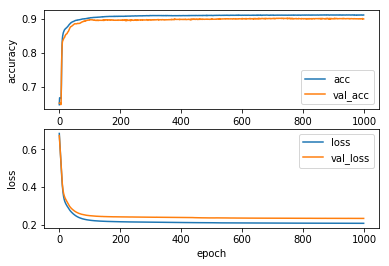

In [417]:
plot(history_TPS)

In [418]:
#NC = nodes correct
model_TPS.save('URZ_model_15-6-2_norm_NC_b2017_TPS.h5')

In [419]:
model_TPS.evaluate(test_X_TPS, test_Y_TPS)

2554/2554 [==============================] - 0s 7us/step


[0.2334805668777288, 0.899177760469232]

#### Test data confusion matrix

In [420]:
Y_pred = numpy.reshape(numpy.argmax(model_TPS.predict(test_X_TPS), axis=1), (test_X_TPS.shape[0],1))

# calculate confusion matrix
C = confusion_matrix(test_Y_TPS_, Y_pred)
print(C)

[[1461  206]
 [  51  836]]


In [421]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

Accuracy: 89.94%


#### Just for curiosity -  Manual associations confusion matrix

In [422]:
Y_pred_man = numpy.argmax(model_TPS.predict(manual_X), axis=1)

# calculate confusion matrix
C = confusion_matrix(manual_Y_TPS_, Y_pred_man)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[3005  999]
 [ 169 1833]]
Accuracy: 80.55%


# Neural network T vs regP 

* we need a new dataset for this

### Dataset for T vs regP

In [423]:
#exclude regS
TP_train = TPS_train[TPS_train['CLASS_PHASE'] != 'regS']
TP_test  = TPS_test [TPS_test ['CLASS_PHASE'] != 'regS']

In [424]:
train_X_TP = TP_train[x_indices].values.astype(float)
train_Y_TP = TP_train[y_indices]

test_X_TP = TP_test[x_indices].values.astype(float)
test_Y_TP = TP_test[y_indices]

#regS = 0, T/regP = 1
train_Y_TP_ = numpy.array(numpy.where(train_Y_TP['CLASS_PHASE'] == 'regP', 1, 0), dtype=float)
test_Y_TP_ = numpy.array(numpy.where(test_Y_TP['CLASS_PHASE'] == 'regP', 1, 0), dtype=float)

#convert to categorical
train_Y_TP = keras.utils.to_categorical(train_Y_TP_)
test_Y_TP = keras.utils.to_categorical(test_Y_TP_)

print(train_X_TP.shape, train_Y_TP.shape, test_X_TP.shape, test_Y_TP.shape)

(15357, 15) (15357, 2) (1667, 15) (1667, 2)


### test if node5 < 0.5 => P

In [425]:
TP_train[y_indices + x_indices]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,tele,0.666667,0.882568,0.958373,0.157113,0.904336,0.485956,-0.821541,-0.821541,0.0,0.000000,0.464077,0.238160,-0.285506,-0.241041,-0.927449
1,tele,0.666667,0.970364,0.907617,0.208997,0.976398,0.394147,-1.056929,-0.780702,0.0,0.000000,-0.140690,-0.259506,-0.345500,-0.357016,-0.012361
2,regP,0.444444,0.972336,0.968170,0.287208,0.719656,0.099224,-0.822671,-0.637867,0.2,0.040000,0.839792,-0.464646,0.022784,-0.850822,-0.665843
3,regP,0.333333,0.961154,0.968608,0.157537,0.887799,0.220673,-1.143233,-1.021936,0.0,0.000000,0.925975,0.187115,-0.342508,-0.593755,-1.253105
4,tele,0.333333,0.921997,0.868067,0.323496,0.944155,0.418986,-0.635144,-0.634917,0.0,0.000000,-0.438348,0.300001,-0.528825,-0.389658,-1.141463
6,regP,0.333333,0.903909,0.719782,0.143259,0.940803,0.159849,-0.904157,-0.318353,0.2,0.255000,0.073768,0.243717,-0.055781,-0.872731,-0.956776
8,tele,0.666667,0.995970,0.995814,0.267105,0.733279,0.643558,-0.982717,-0.982717,0.2,0.165000,-0.493044,-0.791641,-1.105445,-0.871585,-1.040251
9,tele,1.000000,0.972860,0.976111,0.940441,0.155722,0.827822,1.152960,1.511033,0.1,0.160000,0.562585,0.434536,0.901683,0.158088,0.107082
10,tele,0.166667,0.985089,0.969033,0.254518,0.832267,0.382739,-0.978108,-1.262562,0.0,0.000000,-0.063604,-0.291263,-0.209906,-0.672245,-1.195840
11,regP,0.333333,0.956265,0.956891,0.259817,0.892011,0.405170,-0.858268,-0.858268,0.6,0.225714,0.265488,-0.033137,-0.326958,-0.865673,-0.811336


In [299]:
train_Y_TP

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

### Neural network

In [426]:
history_TP = {k : [] for k in hist_keys}

In [427]:
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model_TP = Sequential()
model_TP.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model_TP.add(Dense(2, activation='sigmoid'))

model_TP.compile(
    loss = 'binary_crossentropy', 
    optimizer = 'adam',  # adam, sgd
    metrics = ['accuracy'])

In [428]:
h = model_TP.fit(train_X_TP[:], train_Y_TP[:], 
          epochs=500, 
          batch_size=512, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=([test_X_TP, test_Y_TP]))

history_TP = {k : history_TP[k] + h.history[k] for k in hist_keys}

Train on 15357 samples, validate on 1667 samples
Epoch 1/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.6825 - acc: 0.5731 - val_loss: 0.6788 - val_acc: 0.5708
Epoch 2/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.6763 - acc: 0.5718 - val_loss: 0.6747 - val_acc: 0.5507
Epoch 3/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.6715 - acc: 0.5851 - val_loss: 0.6709 - val_acc: 0.5669
Epoch 4/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.6672 - acc: 0.5986 - val_loss: 0.6671 - val_acc: 0.5810
Epoch 5/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.6628 - acc: 0.6058 - val_loss: 0.6629 - val_acc: 0.5825
Epoch 6/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.6582 - acc: 0.6103 - val_loss: 0.6585 - val_acc: 0.5858
Epoch 7/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.6535 - acc: 0.6148 - val_loss: 0.6541 - val_acc:

15357/15357 [==============================] - 0s 4us/step - loss: 0.4776 - acc: 0.7851 - val_loss: 0.4810 - val_acc: 0.7888
Epoch 61/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4767 - acc: 0.7862 - val_loss: 0.4807 - val_acc: 0.7915
Epoch 62/500
15357/15357 [==============================] - 0s 4us/step - loss: 0.4757 - acc: 0.7862 - val_loss: 0.4796 - val_acc: 0.7897
Epoch 63/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4747 - acc: 0.7866 - val_loss: 0.4790 - val_acc: 0.7939
Epoch 64/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4739 - acc: 0.7868 - val_loss: 0.4780 - val_acc: 0.7924
Epoch 65/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4730 - acc: 0.7875 - val_loss: 0.4773 - val_acc: 0.7927
Epoch 66/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4722 - acc: 0.7879 - val_loss: 0.4765 - val_acc: 0.7933
Epoch 67/500
15357/15357 [=====================

15357/15357 [==============================] - 0s 3us/step - loss: 0.4445 - acc: 0.8088 - val_loss: 0.4500 - val_acc: 0.8131
Epoch 120/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4442 - acc: 0.8092 - val_loss: 0.4502 - val_acc: 0.8140
Epoch 121/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4438 - acc: 0.8094 - val_loss: 0.4496 - val_acc: 0.8164
Epoch 122/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4435 - acc: 0.8093 - val_loss: 0.4493 - val_acc: 0.8161
Epoch 123/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4432 - acc: 0.8099 - val_loss: 0.4488 - val_acc: 0.8152
Epoch 124/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4430 - acc: 0.8106 - val_loss: 0.4483 - val_acc: 0.8155
Epoch 125/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4426 - acc: 0.8110 - val_loss: 0.4490 - val_acc: 0.8140
Epoch 126/500
15357/15357 [==============

15357/15357 [==============================] - 0s 3us/step - loss: 0.4321 - acc: 0.8172 - val_loss: 0.4389 - val_acc: 0.8188
Epoch 179/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4320 - acc: 0.8175 - val_loss: 0.4382 - val_acc: 0.8194
Epoch 180/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4319 - acc: 0.8171 - val_loss: 0.4387 - val_acc: 0.8185
Epoch 181/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4319 - acc: 0.8172 - val_loss: 0.4385 - val_acc: 0.8185
Epoch 182/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4316 - acc: 0.8169 - val_loss: 0.4383 - val_acc: 0.8194
Epoch 183/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4315 - acc: 0.8173 - val_loss: 0.4388 - val_acc: 0.8197
Epoch 184/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4315 - acc: 0.8171 - val_loss: 0.4384 - val_acc: 0.8185
Epoch 185/500
15357/15357 [==============

15357/15357 [==============================] - 0s 3us/step - loss: 0.4282 - acc: 0.8181 - val_loss: 0.4354 - val_acc: 0.8194
Epoch 238/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4282 - acc: 0.8180 - val_loss: 0.4355 - val_acc: 0.8182
Epoch 239/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4282 - acc: 0.8179 - val_loss: 0.4354 - val_acc: 0.8194
Epoch 240/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4281 - acc: 0.8185 - val_loss: 0.4358 - val_acc: 0.8179
Epoch 241/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4280 - acc: 0.8184 - val_loss: 0.4353 - val_acc: 0.8188
Epoch 242/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4281 - acc: 0.8186 - val_loss: 0.4359 - val_acc: 0.8185
Epoch 243/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4281 - acc: 0.8184 - val_loss: 0.4356 - val_acc: 0.8188
Epoch 244/500
15357/15357 [==============

15357/15357 [==============================] - 0s 3us/step - loss: 0.4260 - acc: 0.8189 - val_loss: 0.4339 - val_acc: 0.8209
Epoch 297/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4260 - acc: 0.8186 - val_loss: 0.4333 - val_acc: 0.8194
Epoch 298/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4259 - acc: 0.8192 - val_loss: 0.4342 - val_acc: 0.8200
Epoch 299/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4259 - acc: 0.8186 - val_loss: 0.4333 - val_acc: 0.8191
Epoch 300/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4258 - acc: 0.8189 - val_loss: 0.4338 - val_acc: 0.8194
Epoch 301/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4259 - acc: 0.8188 - val_loss: 0.4332 - val_acc: 0.8188
Epoch 302/500
15357/15357 [==============================] - 0s 4us/step - loss: 0.4258 - acc: 0.8190 - val_loss: 0.4341 - val_acc: 0.8200
Epoch 303/500
15357/15357 [==============

15357/15357 [==============================] - 0s 4us/step - loss: 0.4238 - acc: 0.8197 - val_loss: 0.4319 - val_acc: 0.8206
Epoch 356/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4237 - acc: 0.8200 - val_loss: 0.4318 - val_acc: 0.8209
Epoch 357/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4237 - acc: 0.8200 - val_loss: 0.4318 - val_acc: 0.8203
Epoch 358/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4236 - acc: 0.8200 - val_loss: 0.4318 - val_acc: 0.8203
Epoch 359/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4237 - acc: 0.8191 - val_loss: 0.4322 - val_acc: 0.8212
Epoch 360/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4236 - acc: 0.8202 - val_loss: 0.4315 - val_acc: 0.8206
Epoch 361/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4236 - acc: 0.8198 - val_loss: 0.4321 - val_acc: 0.8206
Epoch 362/500
15357/15357 [==============

Epoch 414/500
15357/15357 [==============================] - 0s 4us/step - loss: 0.4216 - acc: 0.8208 - val_loss: 0.4300 - val_acc: 0.8212
Epoch 415/500
15357/15357 [==============================] - 0s 4us/step - loss: 0.4216 - acc: 0.8208 - val_loss: 0.4301 - val_acc: 0.8200
Epoch 416/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4216 - acc: 0.8204 - val_loss: 0.4302 - val_acc: 0.8194
Epoch 417/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4216 - acc: 0.8203 - val_loss: 0.4302 - val_acc: 0.8203
Epoch 418/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4215 - acc: 0.8203 - val_loss: 0.4302 - val_acc: 0.8185
Epoch 419/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4215 - acc: 0.8208 - val_loss: 0.4300 - val_acc: 0.8203
Epoch 420/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4215 - acc: 0.8210 - val_loss: 0.4301 - val_acc: 0.8185
Epoch 421/500
15357/15357 [

Epoch 473/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4199 - acc: 0.8220 - val_loss: 0.4287 - val_acc: 0.8191
Epoch 474/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4199 - acc: 0.8224 - val_loss: 0.4291 - val_acc: 0.8173
Epoch 475/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4199 - acc: 0.8218 - val_loss: 0.4285 - val_acc: 0.8194
Epoch 476/500
15357/15357 [==============================] - 0s 4us/step - loss: 0.4199 - acc: 0.8221 - val_loss: 0.4287 - val_acc: 0.8182
Epoch 477/500
15357/15357 [==============================] - 0s 4us/step - loss: 0.4198 - acc: 0.8223 - val_loss: 0.4283 - val_acc: 0.8191
Epoch 478/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4198 - acc: 0.8224 - val_loss: 0.4285 - val_acc: 0.8191
Epoch 479/500
15357/15357 [==============================] - 0s 3us/step - loss: 0.4197 - acc: 0.8222 - val_loss: 0.4285 - val_acc: 0.8185
Epoch 480/500
15357/15357 [

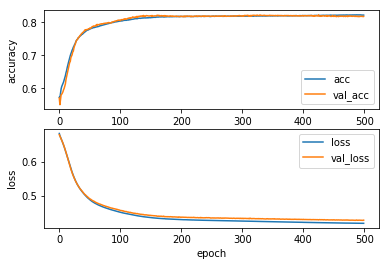

In [429]:
plot(history_TP)

In [430]:
#NC = nodes correct
model_TP.save('URZ_model_15-6-2_norm_NC_b2017_TP.h5')

In [431]:
model_TP.evaluate(test_X_TP, test_Y_TP)

1667/1667 [==============================] - 0s 7us/step


[0.428519556483217, 0.8179364127174565]

#### Test data confusion matrix

In [432]:
Y_pred = numpy.reshape(numpy.argmax(model_TP.predict(test_X_TP), axis=1), (test_X_TP.shape[0],1))

# calculate confusion matrix
conf_mat = confusion_matrix(test_Y_TP_, Y_pred)
print(conf_mat)

[[691 173]
 [133 670]]


# Cascade of all three models

In [433]:
from keras.models import load_model

In [434]:
model_NTPS = load_model('URZ_model_15-6-2_norm_NC_b2017_NTPS.h5')
model_STP = load_model('URZ_model_15-6-2_norm_NC_b2017_TPS.h5')
model_PT = load_model('URZ_model_15-6-2_norm_NC_b2017_TP.h5')

In [435]:
def predict_iwt(X, stage=0):
    """
    predicts initial wave type for given featrue vectors
    Class encoding generated by sklearn Label Encoder
    0 - noise
    2 - regS 
    1 - regP
    3 - T
    """
    Y = numpy.arange(X.shape[0])
    
    N_indices = None
    S_indices = None 
    
    if stage >= 1:
        N_indices = [False] * X.shape[0]
        X_PTS = X
        Y_NPTS = numpy.zeros(X.shape[0])
    if stage >= 2:
        S_indices =  [False] * X.shape[0]  # numpy.array([])
        X_PT = X
        Y_PTS = numpy.zeros(X.shape[0])
        
    
    """
    N vs regS, regP, T
    """
    if N_indices is None:
        #predict N vs T,regP,regS
        Y_NPTS = numpy.argmax(model_NTPS.predict(X), axis=1)
        #set which are noise
        N_indices = Y[Y_NPTS == 1]  #  = 0
        #get candidates for TPS
        X_PTS = X[Y_NPTS < 1]
    else:
        print('Skipping N, classifying TPS only')

    """
    regS vs regP, T
    """
    if S_indices is None:    
        #predict regS vs T,regP
        Y_PTS = numpy.argmax(model_STP.predict(X_PTS), axis=1)
        #set which are regS
        S_indices = Y[Y_NPTS < 1][Y_PTS == 1]  # = 2
        #get candidates for regP,T
        X_PT = X_PTS[Y_PTS < 1]
    else:
        print('Skipping N, regS, classifying TP only')

    """
    regP vs T
    """
    #predict regP vs T
    Y_PT = numpy.argmax(model_PT.predict(X_PT), axis=1)
    #set which are regP
    P_indices = Y[Y_NPTS < 1][Y_PTS < 1][Y_PT == 1]  # = 1    
    #set which are T
    T_indices = Y[Y_NPTS < 1][Y_PTS < 1][Y_PT < 1]   # = 3
    #get those which are T
    X_T = X_PT[Y_PT < 1]
    
    Y[N_indices] = 0 # N
    Y[S_indices] = 2 # regS
    Y[P_indices] = 1 # regP 
    Y[T_indices] = 3 # tele
    
    return Y
    

In [436]:
Y = predict_iwt(test_X)

### Overall confusion matrix for test data

In [437]:
test_X.shape, Y.shape, test_Y_GT.shape

((5108, 15), (5108,), (5108,))

In [438]:
C = confusion_matrix(Y, test_Y_GT)
print(C)

[[2034  127  176  137]
 [ 186  578    3  144]
 [ 227    7  685  161]
 [ 107   91   23  422]]


In [439]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

Accuracy: 72.81%


#### Let's produce result data frame from metadata and results

In [440]:
class_dict = {0:'N', 1:'regP', 2:'regS', 3:'tele'}
Y_pred_cat = [class_dict[yi] for yi in Y]
print(len(Y_pred_cat))

5108


In [441]:
test_metadata = test[metadata]

In [442]:
#let's add new column to the pandas dataframe
#test_metadata['CLASS_IPHASE_NEW'] = Y_pred_cat  # deprecated - gives warning
test_metadata.assign(CLASS_IPHASE_NEW = pd.Series(Y_pred_cat, index=test_metadata.index)).to_csv('test_set_prediction.txt', na_rep='null',columns=metadata+["CLASS_IPHASE_NEW"]) 

In [443]:
### some experiment section..

In [444]:
test_pred_Y = predict_iwt(test_X)

In [445]:
test_X.shape
train_X.shape

(45964, 15)

In [446]:
test_iphase_Y = le.transform(test['CLASS_IPHASE'])
test_truth_Y = le.transform(test['CLASS_PHASE'])

In [447]:
test_truth_Y.min(), test_truth_Y.max()

(0, 3)

In [448]:
test_iphase_Y.min(), test_iphase_Y.max()

(0, 3)

In [449]:
numpy.sum( ) 

TypeError: sum() missing 1 required positional argument: 'a'

In [450]:
#print('IPHASE:')
C = confusion_matrix(test_pred_Y, test_Y_GT)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[2034  127  176  137]
 [ 186  578    3  144]
 [ 227    7  685  161]
 [ 107   91   23  422]]
Accuracy: 72.81%


### Test data just regS, regP, T - not to be confused with overall statistics on all arrivals in our DB

In [451]:
test_TPS = test[test['CLASS_PHASE'] != 'N']
test_TPS_X = test_TPS[x_indices]
test_TPS_pred_Y = predict_iwt(test_TPS_X)
test_TPS_truth_Y = le.transform(test_TPS['CLASS_PHASE'])
test_TPS_iphase_Y = le.transform(test_TPS['CLASS_IPHASE'])

In [452]:
test_TPS_iphase_Y.min(), test_TPS_iphase_Y.max()

(0, 3)

In [453]:
print('IPHASE:')
C = confusion_matrix(test_TPS_iphase_Y, test_TPS_truth_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

IPHASE:
[[  0 140 297 133]
 [  0 565  64 203]
 [  0  26 509 155]
 [  0  72  17 373]]
Accuracy: 56.66%


In [454]:
print('NEW PREDICTION')
C = confusion_matrix(test_TPS_pred_Y, test_TPS_truth_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

NEW PREDICTION
[[  0 127 176 137]
 [  0 578   3 144]
 [  0   7 685 161]
 [  0  91  23 422]]
Accuracy: 65.97%


In [455]:
57/66

0.8636363636363636

In [456]:
51.5/55.5

0.9279279279279279

* in the test data, the current iwt characterized 1501 as NOISE (first row of confusion matrix)
* our new iwt would characterize 1089 as NOISE
* after re-training, accuracy on the test set rose from 58.68% to 65.82% for regS, regP and T phases

#### ..on train data just to see if it works

In [457]:
Y = predict_iwt(train_X)
C = confusion_matrix(Y, train_Y_GT)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[18327  1023  1528  1219]
 [ 1609  5703    21  1253]
 [ 2055    30  5791  1305]
 [  991   953   285  3871]]
Accuracy: 73.30%


### Overall confusion matrix for all manual associations (no Noise)

In [458]:
C = confusion_matrix(predict_iwt(manual_X, stage=1), manual_Y_GT)
print(C)

Skipping N, classifying TPS only
[[1274   66  378]
 [ 266 1833  733]
 [ 462  103  891]]


In [459]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

Accuracy: 66.57%


## Let's try all noise samples we have

In [460]:
# let's get all noise phases not used for training
N_data_diff = pd.concat([df_N_all, N_data]).loc[
    df_N_all.index.symmetric_difference(N_data.index)
]

In [461]:
print(N_data_diff.shape, df_N_all.shape, N_data.shape)
print(N_data_diff.shape[0], 'should equal', df_N_all.shape[0]-N_data.shape[0])

(15801, 25) (41337, 25) (25536, 25)
15801 should equal 15801


In [462]:
N_data_norm = N_data_diff[x_indices].copy(deep=True)
N_data_norm['INANG1'] /= 90.
N_data_norm['INANG3'] /= 90.
N_data_norm['HMXMN'] = numpy.log10(N_data_diff['HMXMN'])
N_data_norm['HVRATP'] = numpy.log10(N_data_diff['HVRATP'])
N_data_norm['HVRAT'] = numpy.log10(N_data_diff['HVRAT'])
N_data_norm['HTOV1'] = numpy.log10(N_data_diff['HTOV1'])
N_data_norm['HTOV2'] = numpy.log10(N_data_diff['HTOV2'])
N_data_norm['HTOV3'] = numpy.log10(N_data_diff['HTOV3'])
N_data_norm['HTOV4'] = numpy.log10(N_data_diff['HTOV4'])
N_data_norm['HTOV5'] = numpy.log10(N_data_diff['HTOV5'])

In [463]:
N_data_norm.shape

(15801, 15)

In [464]:
N_X = N_data_norm[x_indices].values.astype(float)
N_Y = numpy.zeros(N_X.shape[0])

print(N_X.shape, N_Y.shape)

(15801, 15) (15801,)


In [465]:
Y = predict_iwt(N_X)
C = confusion_matrix(Y, N_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[11524     0     0     0]
 [ 1724     0     0     0]
 [ 1454     0     0     0]
 [ 1099     0     0     0]]
Accuracy: 72.93%


* From all avaibale noise phases which were not used for training we are able to correctly identify 83.8%

#### 2017 noise

In [466]:
query = """select * from ml_features where sta='URZ' and class_phase='N' and time between 1483228800 and 1512000000"""
N2017 = pd.read_sql(query, con=connection)

In [467]:
query = """select max(time) from ml_features where sta='URZ' and class_phase='N'"""
%sql $query

0 rows affected.


MAX(TIME)
1516618436.069


In [468]:
N2017.shape

(32502, 25)

In [469]:
N2017_norm = N2017[x_indices].copy(deep=True)
N2017_norm['INANG1'] /= 90.
N2017_norm['INANG3'] /= 90.
N2017_norm['HMXMN'] = numpy.log10(N2017['HMXMN'])
N2017_norm['HVRATP'] = numpy.log10(N2017['HVRATP'])
N2017_norm['HVRAT'] = numpy.log10(N2017['HVRAT'])
N2017_norm['HTOV1'] = numpy.log10(N2017['HTOV1'])
N2017_norm['HTOV2'] = numpy.log10(N2017['HTOV2'])
N2017_norm['HTOV3'] = numpy.log10(N2017['HTOV3'])
N2017_norm['HTOV4'] = numpy.log10(N2017['HTOV4'])
N2017_norm['HTOV5'] = numpy.log10(N2017['HTOV5'])

In [470]:
N2017_X = N2017_norm[x_indices].values.astype(float)
N2017_Y = numpy.zeros(N2017_X.shape[0])

print(N2017_X.shape, N2017_Y.shape)

(32502, 15) (32502,)


In [471]:
Y2017 = predict_iwt(N2017_X)
C = confusion_matrix(Y2017, N2017_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[24459     0     0     0]
 [ 2646     0     0     0]
 [ 3522     0     0     0]
 [ 1875     0     0     0]]
Accuracy: 75.25%


# Let's analyze weights and generate a new weight file!

In [472]:
model_NTPS = load_model('URZ_model_15-6-2_norm_NC_b2017_NTPS.h5')
model_STP = load_model('URZ_model_15-6-2_norm_NC_b2017_TPS.h5')
model_PT = load_model('URZ_model_15-6-2_norm_NC_b2017_TP.h5')

In [473]:
weights_NTPS = model_NTPS.get_weights()
weights_STP = model_STP.get_weights()
weights_PT = model_PT.get_weights()

In [474]:
model_NTPS.get_config()

[{'class_name': 'Dense',
  'config': {'activation': 'sigmoid',
   'activity_regularizer': None,
   'batch_input_shape': (None, 15),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dtype': 'float32',
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'name': 'dense_13',
   'trainable': True,
   'units': 6,
   'use_bias': True}},
 {'class_name': 'Dense',
  'config': {'activation': 'sigmoid',
   'activity_regularizer': None,
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'ker

In [475]:
for w in weights_NTPS:
    print(w.shape)

(15, 6)
(6,)
(6, 2)
(2,)


In [476]:
for w in weights_STP:
    print(w.shape)
    print(w)

(15, 6)
[[-1.3504025   1.8029027   1.0752937  -1.8147367  -0.19719839 -6.0066366 ]
 [-0.13035326  0.3794524   0.66902316  0.48596594  1.1686937   0.45485038]
 [-0.04431636  0.1460176   0.46463802 -0.15589562  0.8350568  -0.5774081 ]
 [-0.10130522 -0.954355   -0.5525805   0.54323584 -1.365458   -1.6869477 ]
 [-1.0050292   1.5222417  -0.78633094  0.1004824   1.1897063   2.631456  ]
 [-0.61187834  0.36636496 -0.1364342   1.409698   -0.5149915  -0.3555087 ]
 [-1.0742751  -0.4786376   0.35567665  1.1393765   1.0050694   1.5824686 ]
 [-0.40859336 -1.1658269  -0.24314396  3.0917017   0.39518002 -1.932091  ]
 [ 2.0160053   0.09929349  2.1506157  -0.38814935  0.62560266 -0.8174789 ]
 [ 0.18860103  0.9081342   1.0591294  -1.5469022   1.8633562   1.4743117 ]
 [-0.4621455  -0.01519931  0.43737584 -1.1329789  -0.68098307  0.25964147]
 [-1.3199338  -0.64655095 -0.48935497  2.0492191   0.70040727  0.07960546]
 [-2.494661    2.19515     1.1474608   4.145903   -1.1050122   2.015151  ]
 [-5.8326316   6.

In [477]:
for w in weights_PT:
    print(w.shape)
    print(w)

(15, 6)
[[-4.7577863   3.5362768  -1.1966748  -4.408807    4.294119    1.2974349 ]
 [ 0.16563976  0.21796976 -0.03590739 -0.07607607 -0.01788964 -1.0969832 ]
 [-0.60708445  0.49959677 -0.12588763 -1.0915283   0.93623775 -0.39424074]
 [-0.2578581  -0.0244083   0.34897602 -1.1668144  -0.61468405 -2.1593623 ]
 [ 0.54869336 -0.52575076 -0.6953618   1.2324096  -0.5414228  -0.6249286 ]
 [-0.44067815  0.0182546  -0.3380955   1.8587604  -0.12335631 -1.2854489 ]
 [-0.48230562  0.2603292  -0.0072317  -0.20880784  0.09105188  0.17678608]
 [-0.47117677  0.48709786  1.3800153   0.08322797  0.11878164 -1.1596879 ]
 [ 3.9023342  -3.679602   -0.1397667   0.17262715 -5.1195073  -4.6744375 ]
 [ 1.1532199  -0.75823796 -1.3836733  -2.6969428  -1.430065    0.1226043 ]
 [ 0.52906007 -0.5026097  -0.07510143 -0.14626738  0.12334096  0.39272338]
 [ 0.88641334 -0.75523645  1.1110917   0.20937903  0.07504348  0.9341909 ]
 [ 1.2367985  -0.90834904  2.0448315   0.33472455  0.09244631  0.35992974]
 [ 0.7110946  -0.

### Let's export it to a weigth file using a template

In [478]:
station_name = 'URZ'

In [479]:
# open template
with open(os.path.join('templates','%s.template' % station_name)) as f:
    template = f.read()
    #print(s)

In [480]:
import datetime
#put name to template
s = template.replace('{{station_name}}', station_name)
s = s.replace('{{date}}', datetime.datetime.now().strftime('%Y/%m/%d %H:%M:%S'))

In [481]:
weight_idents = ('TPSN', 'TPS', 'TP')
weights = (weights_NTPS, weights_STP, weights_PT)

In [482]:
#prepare weights
for ident, w in zip(weight_idents, weights):
    weights_layer_1 = ""
    for i in range(w[0].shape[0]):
        weights_layer_1 += ' '.join(list(map(lambda x: "%7.6f" % x, w[0][i,:])))
        if i < w[0].shape[0] - 1:
            weights_layer_1  += '\n'        
        
    bias_layer_1 = ' '.join(list(map(lambda x: "%7.6f" % x, w[1])))
    
    weights_layer_2 = ""
    for i in range(w[2].shape[0]):
        weights_layer_2 += ' '.join(list(map(lambda x: "%7.6f" % x, w[2][i,:])))
        if i < w[2].shape[0] - 1:
            weights_layer_2  += '\n'        
        
    bias_layer_2 = ' '.join(list(map(lambda x: "%7.6f" % x, w[3])))
    
    #put coefficients into template
    s = s.replace('{{%s_bias_layer_1}}' % ident, bias_layer_1) 
    s = s.replace('{{%s_weights_layer_1}}' % ident, weights_layer_1)
    s = s.replace('{{%s_bias_layer_2}}' % ident, bias_layer_2)
    s = s.replace('{{%s_weights_layer_2}}' % ident, weights_layer_2)
    
#print(bias_layer_1)
#print(weights_layer_1)
#print(bias_layer_2)
#print(weights_layer_2)

In [483]:
print(s)

*-- URZ.nn
*-- Comments ...
*-- Auxiliary 3C station URZ uses the new weights from retraining by RH
*-- Generated 2018/04/05 15:40:59
*-- {{training_summary}}
URZ
3
60.000000
  0.25   0.50   1.00   2.00   4.00
URZ TPS-N
628 3 16 7 2
0.570298 -0.427830 1.998440 -1.836854 2.646599 0.577542
-1.858928 -0.354954 -0.107816 0.039180 1.184743 1.797857
0.627909 1.048414 0.323782 -1.881389 -0.194358 -0.514221
-0.728766 0.562901 -2.132133 0.423228 2.768859 -2.239073
0.035561 -0.127956 1.526894 -1.843269 1.292819 -0.518448
-0.609791 0.139135 -0.308496 0.714771 -1.078287 0.836980
-0.027908 -0.267189 0.359453 4.412441 -3.054602 -0.693398
-0.224899 -0.111377 -0.220502 1.287146 0.519665 0.966511
-1.313558 0.074352 3.971953 -1.863239 2.769125 0.581175
-2.231820 -1.196753 1.673928 0.501908 -1.678193 15.448969
-0.197962 1.984243 -0.865760 1.127029 -2.318171 -3.433863
0.151946 0.113691 -0.106791 0.597073 -0.132469 0.473464
0.775740 -0.509916 -0.296159 0.373442 0.152537 -0.141496
1.582573 -1.602559 -3.5938

In [484]:
#save it
with open(os.path.join('nn_weights','%s_EGU_N16.nn' % station_name), 'w+') as f:
    f.write(s)

### Experiment

(0.166667,0.988657,0.979542,0.182376,0.813614,0.320447,-1.256664,-1.237053,-0.100000,-0.280500,-0.100625,-0.429961,-0.659336,-0.896279,-1.239028) nab=-0.100000 tab=-0.280500

In [219]:
input = numpy.reshape(numpy.array([0.166667,0.988657,0.979542,0.182376,0.813614,0.320447,-1.256664,-1.237053,-0.100000,-0.280500,-0.100625,-0.429961,-0.659336,-0.896279,-1.239028]), (1,15))
#+++++ TPS-N: arid=117647639  node1=0.987806 node2=0.012194
model_NTPS.predict(input)

array([[0.98780584, 0.01219412]], dtype=float32)

In [220]:
#+++++ TP-S: arid=117647639  node3=0.999673 node4=0.000328
model_STP.predict(input)

array([[9.9967265e-01, 3.2784924e-04]], dtype=float32)

In [221]:
#+++++ T-P: arid=117647639  node5=0.537416 node6=0.462994
model_PT.predict(input)

array([[0.53741616, 0.46299383]], dtype=float32)